In [1]:
import os
import numpy as np
import open3d as o3d
# import pypcd4
from matplotlib import pyplot as plt

import plotly.io as pio
pio.renderers.default = "iframe"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Загрузка облака

In [2]:
pcd_path = 'data/points.pcd'

In [3]:
pcd = o3d.io.read_point_cloud(pcd_path)

In [12]:
# pcd.fields

Интенсивность ноль в исходнике у всех точек, про нее можно забыть

In [4]:
points = np.asarray(pcd.points)

points.shape
# (1000, 3)

(9668627, 3)

In [5]:
p_min = points[:, 2].min()

In [6]:
# Нормализуем Z (камера на высоте 1.6 метров, минимум Z = 0)
points[:, 2] = points[:, 2] - p_min - 1.6

In [7]:
points[:, 2].max()

np.float64(64.798193359375)

In [8]:
# нормализация по Z
points[:, 2] -= points[:, 2].min()
points[:, 2] -= 1.6   # смещение на высоту камеры ~1.6 м

In [9]:
from scipy.spatial.distance import cdist
import numpy as np

# Предположим, что у нас есть точки в XY
xy = points[:, :2]  # (N, 2)
# center_line
# Упорядочиваем точки по направлению движения (по увеличению x или по дистанции)
# Можно использовать алгоритм "greedy path" или просто сортировать по x
sorted_idx = np.argsort(xy[:, 0])  # если дорога идёт слева направо
xy_sorted = xy[sorted_idx]

# Теперь строим центральную линию — например, медиана по Y на каждом интервале X
# Разбиваем на бины по X и берем центр каждого бина
bin_size = 50  # пиксели или метры
x_bins = np.arange(xy_sorted[:, 0].min(), xy_sorted[:, 0].max(), bin_size)
center_line_x = []
center_line_y = []

for x_bin in x_bins:
    mask = (xy_sorted[:, 0] >= x_bin) & (xy_sorted[:, 0] < x_bin + bin_size)
    if np.any(mask):
        y_med = np.median(xy_sorted[mask, 1])
        center_line_x.append(x_bin + bin_size / 2)
        center_line_y.append(y_med)

center_line = np.column_stack([center_line_x, center_line_y])

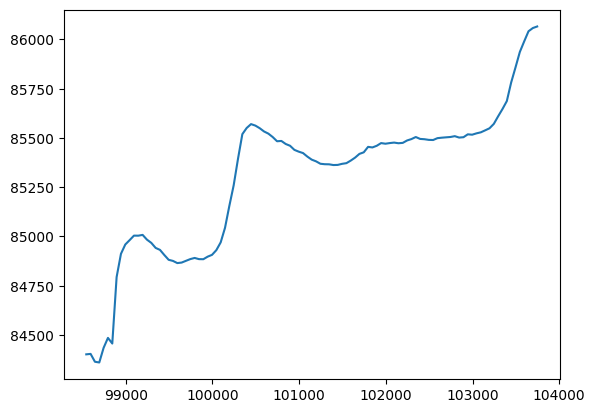

In [19]:
plt.plot(center_line[:, 0], center_line[:, 1])

In [20]:
len(center_line)

105

### Режем на кубики вдоль траектории

In [11]:
def create_cubes_along_trajectory(points, center_line, cube_side=500, line_step=5, width_offset=150):
    cubes = []
    half = cube_side / 2.0

    for i in range(0, len(center_line) - line_step, line_step):
        p1, p2 = center_line[i], center_line[i + line_step]
        direction = p2 - p1
        direction = direction / np.linalg.norm(direction)
        normal = np.array([-direction[1], direction[0]])  # перпендикуляр

        center = (p1 + p2) / 2.0
        rel_points = points[:, :2] - center

        # условие попадания в куб по оси вдоль траектории и по перпендикуляру
        mask = (
            (np.abs(rel_points @ direction) < half) &
            (np.abs(rel_points @ normal) < width_offset)
        )
        cube = points[mask]
        if len(cube) > 0:
            cubes.append(cube)

    return cubes


In [12]:
cubes = create_cubes_along_trajectory(points, center_line, cube_side=500, line_step=5, width_offset=150)

In [13]:
len(cubes)

20

In [14]:
cubes[1].shape

(376016, 3)

In [25]:
import os

os.makedirs("data/cubes2", exist_ok=True)

In [26]:
for i, cube in enumerate(cubes):
    np.save(f"data/cubes2/{i}.npy", cube)
    cube_pcd = o3d.geometry.PointCloud()
    cube_pcd.points = o3d.utility.Vector3dVector(cube[:, :3])
    o3d.io.write_point_cloud(f"data/cubes2/{i}.pcd", cube_pcd)

### Сохранение одного кубика и визуализация для OpenPCDet

In [28]:
np_path = 'data/points.npy'

np.save(np_path, points) 

In [15]:
pcd = o3d.io.read_point_cloud(pcd_path)
pcd.points = o3d.utility.Vector3dVector(cubes[0][:, :3])

In [16]:
def draw_pcd(points, voxel_size=5.0):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points[:, :3])
    pcd_down = pcd.voxel_down_sample(voxel_size=voxel_size)
    o3d.visualization.draw_plotly([pcd_down])

# пример: первый кубик
draw_pcd(cubes[0])

In [8]:
points = np.asarray(pcd.points, dtype=np.float32)

### Сохранение для OpenPCDet (демо-инференс)

In [17]:
import os
import numpy as np
import open3d as o3d

# === Параметры ===
DATASET_ROOT = "data/opencdet_cubes"        # корень датасета
SPLIT = "testing"                           # под демо удобно сделать testing
VEL_DIR = os.path.join(DATASET_ROOT, SPLIT, "velodyne")
IMGSETS = os.path.join(DATASET_ROOT, "ImageSets")
SAVE_NPY = True                             # сохранить параллельно .npy

os.makedirs(VEL_DIR, exist_ok=True)
os.makedirs(IMGSETS, exist_ok=True)

def to_kitti_bin(points_xyz_any) -> bytes:
    """
    Принимает массив (N,>=3) и возвращает bytes для KITTI .bin
    Формат: float32 [x, y, z, intensity]
    Если интенсивности нет — ставим 1.0 (или 0.0 по желанию).
    """
    pts = np.asarray(points_xyz_any, dtype=np.float32)
    if pts.shape[1] < 3:
        raise ValueError("points must have at least 3 columns (x,y,z)")
    xyz = pts[:, :3].astype(np.float32)

    if pts.shape[1] >= 4:
        intensity = pts[:, 3:4].astype(np.float32)
    else:
        intensity = np.ones((pts.shape[0], 1), dtype=np.float32)  # можно заменить на zeros

    xyzi = np.concatenate([xyz, intensity], axis=1)  # (N,4)
    return xyzi.astype(np.float32).tobytes()

# === Сохранение всех кубиков ===
id_list = []
for i, cube in enumerate(cubes):
    base = f"{i:06d}"
    bin_path = os.path.join(VEL_DIR, base + ".bin")
    npy_path = os.path.join(VEL_DIR, base + ".npy")

    # .bin (KITTI-style)
    with open(bin_path, "wb") as f:
        f.write(to_kitti_bin(cube))

    # .npy (на всякий случай/отладка)
    if SAVE_NPY:
        np.save(npy_path, cube)

    id_list.append(base)

# ImageSets/test.txt
with open(os.path.join(IMGSETS, "test.txt"), "w") as f:
    for bid in id_list:
        f.write(bid + "\n")

print(f"Сохранено {len(id_list)} сэмплов в {VEL_DIR}")
print(f"Список id записан в {os.path.join(IMGSETS, 'test.txt')}")


Сохранено 20 сэмплов в data/opencdet_cubes/testing/velodyne
Список id записан в data/opencdet_cubes/ImageSets/test.txt


Визуализация любого сохранённого сэмпла

In [18]:
def load_kitti_bin(path_bin: str) -> np.ndarray:
    raw = np.fromfile(path_bin, dtype=np.float32)
    pts = raw.reshape(-1, 4)  # x,y,z,intensity
    return pts

def draw_pcd_points(points_xyz, voxel_size=5.0):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_xyz[:, :3])
    pcd_down = pcd.voxel_down_sample(voxel_size=float(voxel_size))
    o3d.visualization.draw_plotly([pcd_down])

# пример: показать 0-й сэмпл из velodyne
sample_bin = os.path.join(VEL_DIR, f"{0:06d}.bin")
pts = load_kitti_bin(sample_bin)
draw_pcd_points(pts, voxel_size=5.0)


### Визуализация боксов

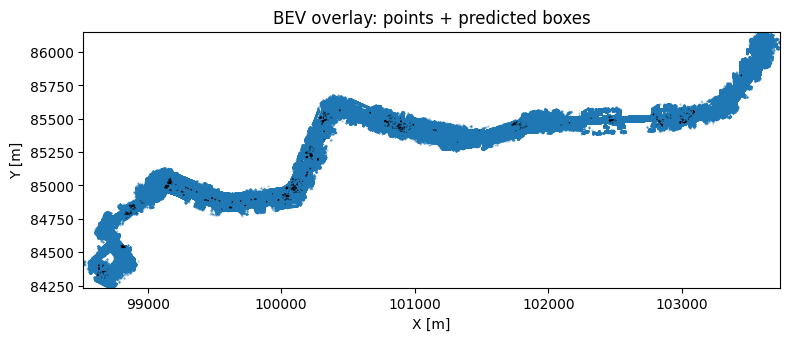

Saved BEV PNG → data/bev_overlay.png


In [24]:
# --- ПАРАМЕТРЫ ---
pcd_path    = "data/points.pcd"                     # исходное облако
preds_path  = "data/opencdet_cubes/merged_preds.npz" # объединённые предсказания (global)
png_out     = "data/bev_overlay.png"                # куда сохранить PNG

score_thr   = 0.25      # порог для отрисовки боксов
max_boxes   = 2000      # ограничение на число боксов для читаемости
downsample  = 5         # брать каждую N-ю точку (ускоряет отрисовку), 1 = без даунсэмплинга
figsize     = (8, 8)    # размер рисунка
point_size  = 0.2       # размер точки на scatter
alpha_pts   = 0.5       # прозрачность точек
draw_scores = False     # подписывать score у боксов (может загромождать)

# --- КОД ---
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def bev_corners_xy(boxes_xyzlwh_yaw: np.ndarray) -> np.ndarray:
    """
    boxes: [N,7] -> (x,y,z, dx,dy,dz, yaw)
    return: XY-углы в порядке (4,2) на каждый бокс -> [N,4,2]
    """
    c = np.cos(boxes_xyzlwh_yaw[:, 6])
    s = np.sin(boxes_xyzlwh_yaw[:, 6])
    R = np.stack([np.stack([c, -s], axis=1),
                  np.stack([s,  c], axis=1)], axis=1)        # [N,2,2]

    dx = boxes_xyzlwh_yaw[:, 3] / 2.0
    dy = boxes_xyzlwh_yaw[:, 4] / 2.0

    # локальные углы прямоугольника в порядке: (-,-), (+,-), (+,+), (-,+)
    templ = np.stack([
        np.stack([-dx, -dy], axis=1),
        np.stack([+dx, -dy], axis=1),
        np.stack([+dx, +dy], axis=1),
        np.stack([-dx, +dy], axis=1),
    ], axis=1)                                             # [N,4,2]

    # поворот + перенос
    rot = templ @ np.transpose(R, (0,2,1))                 # [N,4,2]
    rot[:,:,0] += boxes_xyzlwh_yaw[:, 0][:, None]          # x0
    rot[:,:,1] += boxes_xyzlwh_yaw[:, 1][:, None]          # y0
    return rot

# 1) читаем данные
pcd = o3d.io.read_point_cloud(pcd_path)
pts = np.asarray(pcd.points, dtype=np.float32)
if len(pts) == 0:
    raise RuntimeError("PCD пустой.")

preds = np.load(preds_path, allow_pickle=True)
boxes  = preds["boxes"]    # ожидаем [M,7] в глобальных координатах
scores = preds["scores"] if "scores" in preds else np.ones(len(boxes), np.float32)
labels = preds["labels"] if "labels" in preds else np.zeros(len(boxes), np.int32)

# 2) фильтруем
mask = scores >= score_thr
boxes, scores, labels = boxes[mask], scores[mask], labels[mask]

if len(boxes) > max_boxes:
    order = np.argsort(-scores)[:max_boxes]
    boxes, scores, labels = boxes[order], scores[order], labels[order]

# 3) BEV-проекции
corners = bev_corners_xy(boxes)  # [M,4,2]

# 4) отрисовка
plt.figure(figsize=figsize)
pts_xy = pts[::downsample, :2] if downsample > 1 else pts[:, :2]
plt.scatter(pts_xy[:,0], pts_xy[:,1], s=point_size, alpha=alpha_pts)

ax = plt.gca()
for i, cs in enumerate(corners):
    poly = Polygon(cs, closed=True, fill=False, linewidth=0.8)
    ax.add_patch(poly)
    if draw_scores:
        cx, cy = boxes[i, 0], boxes[i, 1]
        ax.text(cx, cy, f"{scores[i]:.2f}", fontsize=6)

ax.set_aspect("equal", adjustable="box")
plt.xlabel("X [m]"); plt.ylabel("Y [m]")
plt.title("BEV overlay: points + predicted boxes")

# подгоним границы под точки (с небольшим паддингом)
x_min, y_min = pts_xy.min(axis=0)
x_max, y_max = pts_xy.max(axis=0)
pad = 3.0
plt.xlim(x_min - pad, x_max + pad)
plt.ylim(y_min - pad, y_max + pad)

plt.tight_layout()
plt.savefig(png_out, dpi=200)
plt.show()

print(f"Saved BEV PNG → {png_out}")
